In [2]:
# imports
import Constants as c                           # constanst
import Functions as f                           # functions
import pandas as p                              # pandas
import numpy as np                              # numpy
import datetime as dt                           # datetime module for time intervals
from sklearn.cluster import DBSCAN              # DBSCAN algorithm
from sklearn.cluster import HDBSCAN             # HDBSCAN algorithm
import hdbscan as hdbs                          # improved (faster) HDBSCAN https://github.com/scikit-learn-contrib/hdbscan, https://joss.theoj.org/papers/10.21105/joss.00205
import matplotlib.pyplot as plt                 # plot
import gc                                       # garbage collector
from scipy.spatial import ConvexHull            # ConvexHulls for clusters
from shapely.geometry.polygon import Polygon    # for operations on clusters
import statistics as s                          # for statistics
import pickle                                   # for exporting the final result

# map plotting
import shapely as shpl               
import plotly.express as px
import plotly.offline as po
import plotly.graph_objects as go


Import source csv into a dataframe

In [3]:
FILE_NAME = '2019_01-03.csv'
clean_df = p.read_csv(c.FOLDER_PATH + FILE_NAME)
print(f'Dataframe shape: {clean_df.shape}')
print(clean_df.columns)
print(clean_df.shape)

Dataframe shape: (5462415, 17)
Index(['MMSI', 'BaseDateTime', 'LAT', 'LON', 'SOG', 'COG', 'Heading',
       'VesselName', 'IMO', 'CallSign', 'VesselType', 'Status', 'Length',
       'Width', 'Draft', 'Cargo', 'TransceiverClass'],
      dtype='object')
(5462415, 17)


Columns dtypes optimization in order to reduce RAM usage <br>
(=casting to smaller dtypes)

In [4]:
optimized_df = p.DataFrame()

# MMSI - 9 digits number, converted from int64 to int32
optimized_df['MMSI'] = clean_df['MMSI'].astype('int32')

# BaseDateTime - from str to numpy.datetime64 (68 bytes -> 40 Bytes)
optimized_df['BaseDateTime'] = clean_df['BaseDateTime'].astype('datetime64[s]')

# LAT - No action. Just want to make sure to not loose precision 
optimized_df['LAT'] = clean_df['LAT']

# LON - No action. Just want to make sure to not loose precision 
optimized_df['LON'] = clean_df['LON']

# SOG - No action
optimized_df['SOG'] = clean_df['SOG']

# COG - No action
optimized_df['COG'] = clean_df['COG']

# Heading - No action
optimized_df['Heading'] = clean_df['Heading']

# VesselName - specify string dtype
optimized_df['VesselName'] = clean_df['VesselName'].astype(p.StringDtype())

# IMO - specify string dtype
optimized_df['IMO'] = clean_df['IMO'].astype(p.StringDtype())

# CallSign - specify string dtype
optimized_df['CallSign'] = clean_df['CallSign'].astype(p.StringDtype())

# VesselType - from float64 to int16. Following AIS specification, VesselType maximum value is around 1000
clean_df['VesselType'] = clean_df['VesselType'].fillna(value=0) # replaces all None values with zero.
optimized_df['VesselType'] = clean_df['VesselType'].astype('int16')

# Status - from float64 to int8. Following AIS specification, there are 16 (0-15) status codes
clean_df['Status'] = clean_df['Status'].fillna(value=99) # since 0 is a valid status code, 99 is used as a placeholder for None values
optimized_df['Status'] = clean_df['Status'].astype('int8')

# Length - from float64 to int16. Any floating point value is truncated to the closest integer.
# This is done on purpouse as an error of fractions of a meter is bearable.
clean_df['Length'] = clean_df['Length'].fillna(value=0)
optimized_df['Length'] = clean_df['Length'].astype('int16')

# Width - from float64 to int16. Any floating point value is truncated to the closest integer.
# This is done on purpouse as an error of fractions of a meter is bearable.
clean_df['Width'] = clean_df['Width'].fillna(value=0)
optimized_df['Width'] = clean_df['Width'].astype('int16')

# Draft - from float64 to float32
optimized_df['Draft'] = clean_df['Draft'].astype('float32')

# Cargo - from float64 to int16. Similar to VesselType
clean_df['Cargo'] = clean_df['Cargo'].fillna(value=0)
optimized_df['Cargo'] = clean_df['Cargo'].astype('int16')

# TransceiverClass - from string object to boolean. The new column ('IsClassA') holds True if the transceiver 
# is of type 'class A', false if it is of type 'class B'
optimized_df['IsClassA'] = clean_df['TransceiverClass'].map({'A':True, 'B':False})

# Round lat and lon values to 4 decimal digits (instead of 5)
optimized_df[['LAT','LON']] = optimized_df[['LAT','LON']].round(4)

print(clean_df.info())

print(optimized_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5462415 entries, 0 to 5462414
Data columns (total 17 columns):
 #   Column            Dtype  
---  ------            -----  
 0   MMSI              int64  
 1   BaseDateTime      object 
 2   LAT               float64
 3   LON               float64
 4   SOG               float64
 5   COG               float64
 6   Heading           float64
 7   VesselName        object 
 8   IMO               object 
 9   CallSign          object 
 10  VesselType        float64
 11  Status            float64
 12  Length            float64
 13  Width             float64
 14  Draft             float64
 15  Cargo             float64
 16  TransceiverClass  object 
dtypes: float64(11), int64(1), object(5)
memory usage: 708.5+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5462415 entries, 0 to 5462414
Data columns (total 17 columns):
 #   Column        Dtype        
---  ------        -----        
 0   MMSI          int32        
 1   BaseDateTim

Source: Pallotta, G., Vespe, M., & Bryan, K. (2013). Vessel Pattern Knowledge Discovery from AIS Data: A Framework for Anomaly Detection and Route Prediction. Entropy, 15(12), 2218–2245. https://doi.org/10.3390/e15062218

‌TREAD algorithm (pages 2223-2231)

In [5]:
# From the complete db, select only the necessary columns
optimized_df = optimized_df[['MMSI', 'BaseDateTime', 'LAT', 'LON', 'SOG', 'COG', 'Heading',
                            'VesselName', 'VesselType', 'Status', 'Length',
                            'Width', 'Draft', 'IsClassA']].copy()
# Drop duplicates, just in case
optimized_df.drop_duplicates(subset=['MMSI', 'BaseDateTime'], keep='first', inplace=True, ignore_index=True)
optimized_df = optimized_df.sort_values(by='BaseDateTime')

reference_list_of_mmsi = p.unique(optimized_df['MMSI']).tolist()
reference_list_of_mmsi.sort()

V_s = [] # List of dataframes. Each dataframe represents a Vessel (and its journey)

# for each ship
for mmsi in reference_list_of_mmsi:
    # Extract all points generated by the ship
    appendDF = p.DataFrame(optimized_df[optimized_df['MMSI'] == mmsi])
    # Add a new column for storing the average speed between the current point and the previous
    appendDF['Avg_Speed'] = p.Series(dtype=p.Float64Dtype())
    # reset the index of the dataframe
    appendDF.reset_index(inplace=True)

    # next step: calculate the avg_speed (distance/time) in order to find stationary points. (SOG is not always reliable)
    # for the distance, the great-circle distance is used in order to account for earth curvature
    
    # save a shifted-by-one-row version of the db, so that "previous" points can be joined with "current" points
    shiftedDF = appendDF[['BaseDateTime','LAT', 'LON']].shift(1).copy()
    # the resulting df has (for each row) a pair of points. The left one is antecedent to the right one
    pairsOfPointsDF = shiftedDF.iloc[1:].join(appendDF[['BaseDateTime', 'LAT', 'LON', 'SOG']].iloc[1:], lsuffix='_left', rsuffix='_right')
    # calculate average speed for each row of the 'pairsOfPointsDF' df (each row represents a pair of points)
    # add a new column that holds the time difference between the two points of the row
    pairsOfPointsDF['DeltaTime'] = p.to_datetime(pairsOfPointsDF['BaseDateTime_right']) - p.to_datetime(pairsOfPointsDF['BaseDateTime_left'])
    # add a new column that holds the distance (in meters) between the two points of the same row
    pairsOfPointsDF['Distance'] = f.great_circle_distance_vectorized( pairsOfPointsDF['LAT_left'],
                                                                    pairsOfPointsDF['LON_left'],
                                                                    pairsOfPointsDF['LAT_right'],
                                                                    pairsOfPointsDF['LON_right']
                                                                    )
    # calculate average speed (in m/s)
    pairsOfPointsDF['Speed'] = pairsOfPointsDF['Distance'] / pairsOfPointsDF['DeltaTime'].dt.total_seconds()

    # sometimes a vessel can stop reporting its position and re-appear too far away from its last known location.
    # In this case it makes little sense to calculate the avg_speed. (np.nan multiplied by any number returns np.nan)
    
    # condition used to determine if the ship is "lost"
    lost_condition = (pairsOfPointsDF['DeltaTime'] > c.LOST_TIME_THRESHOLD_SECONDS)
    # another codition used to determine if the ship has left the domain for a significant amount of time
    exit_condition = (pairsOfPointsDF['DeltaTime'] > c.EXIT_TIME_THRESHOLD_HOURS)
    # the avg_speed of the points following the ones considered "lost" 
    # (which includes also vessels that satisfy the Exit condition) is set to nan
    pairsOfPointsDF.loc[lost_condition, 'Speed'] = np.nan
    # any nan point of the 'Speed' column is set to the corresponging 'SOG' value (if available and reliable)
    pairsOfPointsDF['Speed'] = pairsOfPointsDF['Speed'].fillna(
                                                                p.Series(
                                                                    np.where((  pairsOfPointsDF['SOG'] < c.ABSURD_SPEED_THRESHOLD), #if I have to rely on the SOG, check if it is plausible (verosimile)
                                                                                pairsOfPointsDF['SOG']/c.KNOTS_CONST, # if yes, use the SOG value (converted in m/s)
                                                                                pairsOfPointsDF['Distance'] / pairsOfPointsDF['DeltaTime'].dt.total_seconds() # if no, calculate it again
                                                                            )))
    
    # Add a new column for storing the status of the ship (according to TREAD algorithm, see above)
    pairsOfPointsDF['EstimatedStatus'] = p.Series(dtype=p.StringDtype())

    # set the status of the last and first points before (lost) and after (return) a small interruption
    pairsOfPointsDF.loc[lost_condition.shift(-1, fill_value=False), 'EstimatedStatus'] = 'lost'
    pairsOfPointsDF.loc[lost_condition, 'EstimatedStatus'] = 'return'
    # set the status of the last and first points before (exit) and after (entry) a big interruption
    pairsOfPointsDF.loc[exit_condition.shift(-1, fill_value=False), 'EstimatedStatus'] = 'exit'
    pairsOfPointsDF.loc[exit_condition, 'EstimatedStatus'] = 'entry'

    # convert the speed from meters to nautical knots
    pairsOfPointsDF['Speed'] = pairsOfPointsDF['Speed'] * c.KNOTS_CONST
    # round the final value to 2 decimal digits
    pairsOfPointsDF['Speed'] = pairsOfPointsDF['Speed'].round(decimals=2)
    
    # save the speed values to the ship df
    appendDF['Avg_Speed'] = pairsOfPointsDF['Speed'].copy()
    # The first row of each ship has its "Avg_Speed" field set equal to the SOG (due to lazyness this time the reliability of the SOG value is not checked)
    appendDF.at[appendDF.index[0], 'Avg_Speed'] = appendDF.at[appendDF.index[0], 'SOG']
    # Any row where avg_speed is set to np.nan is replaced with the SOG value
    appendDF.fillna({'Avg_Speed' : appendDF['SOG']}, inplace=True)    
    
    # Sometimes a vessel may broadcast an impossible GPS location. This is detected by looking for 
    # absurd values in the freshly calculated 'Avg_Speed' field. Any point that fits this description is then dropped.
    appendDF = appendDF[appendDF['Avg_Speed'] < c.ABSURD_SPEED_THRESHOLD]
    
    # Copy the estimated status column in the final ship df
    appendDF['EstimatedStatus'] = pairsOfPointsDF['EstimatedStatus'].copy()

    # drop the first column (generated during all the processing above)
    appendDF.drop('index', axis=1, inplace=True)
    # Rename the dataframe to the corresponding ship MMSI
    appendDF.name = str(mmsi)
    appendDF._metadata += ['name'] # this is necessary otherwise copying the dataframe will make it loose its name (why? ask Pandas, I don't know)
    # save the dataframe to the vessels list
    V_s.append(appendDF)

display(V_s[-1].head())

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,VesselType,Status,Length,Width,Draft,IsClassA,Avg_Speed,EstimatedStatus
0,983728083,2019-01-18 20:44:07,21.3010,-157.8659,0.3,312.2,511.0,<NA>,0,15,0,0,NaN,True,0.30,<NA>
1,983728083,2019-01-18 20:45:18,21.3010,-157.8658,0.0,0.0,511.0,<NA>,0,15,0,0,NaN,True,0.28,<NA>
2,983728083,2019-01-18 20:46:27,21.3011,-157.8658,0.0,159.8,511.0,<NA>,0,15,0,0,NaN,True,0.31,<NA>


In [6]:
# delete unused dataframe from RAM in order to save memory
# according to StackOverflow, this is the best way: 
# https://stackoverflow.com/questions/64368565/delete-and-release-memory-of-a-single-pandas-dataframe

del pairsOfPointsDF
del appendDF
del shiftedDF
del clean_df
gc.collect()

0

Next part of the TREAD algorithm</br>

Consider as stationary all points where the estimated average speed is lower then a set threshold</br>
Consider the first (entry) and last (exit) recorded points of each ship as 'stationary', regardless of the estimated speed.</br>
Set all remaing points as 'sailing'</br>

In [7]:
# for each vessel (dataframe) in the V_s list,
for index, shipDF in enumerate(V_s):
    # check that the ships are read in the same order
    if shipDF.name != str(reference_list_of_mmsi[index]):
        print('Error with ships order')

    # set the status of each point where the avg_speed is lower than the given threshold to 'stationary'
    shipDF['EstimatedStatus'] = np.where(((shipDF["Avg_Speed"] <= c.SPEED_THRESHOLD) &
                                         (shipDF['EstimatedStatus'].isnull())),
                                         'stationary', shipDF['EstimatedStatus'])
    # set all remaining null points as "sailing"
    shipDF['EstimatedStatus'] = np.where(((shipDF["Avg_Speed"] > c.SPEED_THRESHOLD) & 
                                         (shipDF['EstimatedStatus'].isnull())),
                                          'sailing', shipDF['EstimatedStatus'])
    # set the first and last points of each ship as "entry" and "exit" points respectively
    shipDF.loc[shipDF.index[0:1], 'EstimatedStatus'] = 'entry'
    shipDF.loc[shipDF.index[-1:], 'EstimatedStatus'] = 'exit'
    
    # sometimes a few consecutive points (for the same vessel) might be all with status 'entry' or 'exit'
    # this is unwanted and only one of those points is kept.
    # The rule is: keep the last of any consecutive 'entry' point and keep the first of any consecutive 'exit' point
    
    tempDF = shipDF[(shipDF['EstimatedStatus'] == 'entry') | (shipDF['EstimatedStatus'] == 'exit')] 

    condition_entry  = (
                        (tempDF['EstimatedStatus'] == 'entry') &
                        (tempDF['EstimatedStatus'].shift(-1) == tempDF['EstimatedStatus'])
                        )
    condition_exit =(
                        (tempDF['EstimatedStatus'] == 'exit') &
                        (tempDF['EstimatedStatus'].shift(1) == tempDF['EstimatedStatus'])
                    )
    # save the index of rows that need to be removed
    bad_entry_index = tempDF[condition_entry].index.to_list()
    bad_exit_index = tempDF[condition_exit].index.to_list()
    # if any of the above list is not empty
    if bad_entry_index or bad_exit_index:
        final_bad_index = bad_entry_index + bad_exit_index
        final_bad_index.sort()
        print(f'Removed duplicate entry or exit point at index {final_bad_index}.')
        print(f'Previous ship len: {shipDF.shape[0]}')
        shipDF = shipDF.drop(index=final_bad_index).reset_index()
        print(f'Current ship len: {shipDF.shape[0]}')
    # update the list of vessel with the updated values
    V_s[index] = shipDF

del shipDF
del tempDF
gc.collect()

Removed duplicate entry or exit point at index [0].
Previous ship len: 35
Current ship len: 34
Removed duplicate entry or exit point at index [0, 9, 32, 33, 34].
Previous ship len: 37
Current ship len: 32
Removed duplicate entry or exit point at index [1336].
Previous ship len: 1359
Current ship len: 1358
Removed duplicate entry or exit point at index [1460].
Previous ship len: 1826
Current ship len: 1825
Removed duplicate entry or exit point at index [0].
Previous ship len: 15
Current ship len: 14
Removed duplicate entry or exit point at index [796].
Previous ship len: 6316
Current ship len: 6315
Removed duplicate entry or exit point at index [0].
Previous ship len: 3
Current ship len: 2
Removed duplicate entry or exit point at index [16].
Previous ship len: 17
Current ship len: 16
Removed duplicate entry or exit point at index [0].
Previous ship len: 14
Current ship len: 13
Removed duplicate entry or exit point at index [655, 656].
Previous ship len: 1081
Current ship len: 1079
Remov

0

,MMSI,BaseDateTime,SOG,Avg_Speed,EstimatedStatus
2240,9107059,2019-01-20 05:14:01,0.0,0.00,stationary
2241,9107059,2019-01-20 05:20:01,0.0,0.00,stationary
2242,9107059,2019-01-20 05:23:01,2.1,0.16,stationary
2243,9107059,2019-01-20 05:25:12,5.3,4.50,sailing
2244,9107059,2019-01-20 05:30:00,6.2,5.79,sailing
2245,9107059,2019-01-20 05:31:12,6.2,6.37,sailing
2246,9107059,2019-01-20 05:33:00,6.3,6.37,sailing
2247,9107059,2019-01-20 05:34:57,6.2,6.16,sailing
2248,9107059,2019-01-20 05:36:12,6.2,6.11,sailing
2249,9107059,2019-01-20 05:37:57,6.1,6.26,sailing


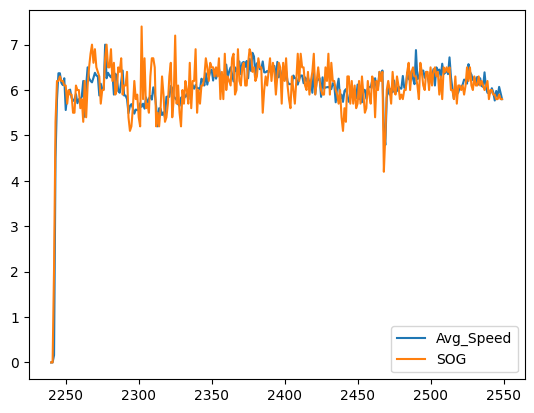

In [8]:
# print a dataframe and some points just to check the result
interval = range(2240,2550)
display(V_s[2].loc[interval, ['MMSI', 'BaseDateTime', 'SOG', 'Avg_Speed', 'EstimatedStatus']].head(10))
plt.plot(V_s[2].loc[interval,'Avg_Speed'])
plt.plot(V_s[2].loc[interval,'SOG'])
plt.legend(['Avg_Speed', 'SOG'])

In [9]:
# aggregate all the points back into a single dataframe
concatDF = p.concat(V_s, ignore_index=True).copy()

# Extract all the stationary points in a single dataframe
stationaryDF = p.DataFrame(columns=V_s[0].columns) # new empty df

# stationary points include all points that are useful for extracting routes
stationaryDF = concatDF[(concatDF['EstimatedStatus'] == 'stationary') |
                        (concatDF['EstimatedStatus'] == 'entry') |
                        (concatDF['EstimatedStatus'] == 'exit')
                        ].copy()

stationaryDF.reset_index(inplace=True)

print(f'{(stationaryDF.shape[0]/optimized_df.shape[0]) * 100: .2f}% of points are stationary!')

 69.20% of points are stationary!


In [10]:
# Some computationl tricks in order to save some time
print(f'Currently there are {stationaryDF.shape[0]} stationary points!')
# Group-by same (lat,lon) pairs and count occurrencies
groupedDF = stationaryDF.groupby(['LAT', 'LON']).size().reset_index(name='Weight')
print(f'The new df has {groupedDF.shape[0]} rows!')
print("Pair with most occurrencies: \n" + str(groupedDF.iloc[groupedDF['Weight'].idxmax(), :]) + '\n')

# Apply log2() (base-2 logarithm) to the 'weight' column in order to rescale its values
groupedDF['Weight'] = np.round(
                                np.log2(groupedDF['Weight']),
                                decimals=0
                            )
# The minimum weight should be 1, so any zero is arbitrarly replaced
groupedDF['Weight'] = groupedDF['Weight'].replace(0,1)

display(p.concat([groupedDF.head(5), groupedDF.tail(5)]))

print("Pair with most occurrencies: \n" + str(groupedDF.iloc[groupedDF['Weight'].idxmax(), :]) + '\n')

Currently there are 3778790 stationary points!
The new df has 54345 rows!
Pair with most occurrencies: 
LAT          21.2970
LON        -158.1065
Weight    61877.0000
Name: 38040, dtype: float64



,LAT,LON,Weight
0,18.7665,-155.7773,1.0
1,18.7666,-156.9702,1.0
2,18.7667,-156.8071,1.0
3,18.7669,-156.6011,1.0
4,18.7669,-156.5696,1.0
54340,22.6307,-156.3146,1.0
54341,22.6308,-158.4875,1.0
54342,22.6308,-156.8662,1.0
54343,22.6308,-155.5218,1.0
54344,22.6309,-158.3782,1.0


Pair with most occurrencies: 
LAT        21.2970
LON      -158.1065
Weight     16.0000
Name: 38040, dtype: float64



DBSCAN(eps=0.075, min_samples=10) len: 54345, num of clusters: 56


,LAT,LON,Weight,Label
0,18.7665,-155.7773,1.0,1
1,18.7666,-156.9702,1.0,-1
2,18.7667,-156.8071,1.0,-1
3,18.7669,-156.6011,1.0,-1
4,18.7669,-156.5696,1.0,-1
54340,22.6307,-156.3146,1.0,54
54341,22.6308,-158.4875,1.0,-1
54342,22.6308,-156.8662,1.0,51
54343,22.6308,-155.5218,1.0,56
54344,22.6309,-158.3782,1.0,55


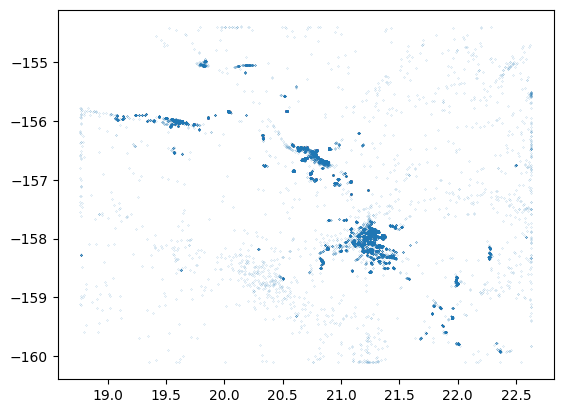

In [11]:
# Run DBSCAN algorithm on the grouped stationary points

# this scatter plot gives a rough idea of how the points should look like plotted on a map
plt.scatter(groupedDF.iloc[:,0], groupedDF.iloc[:,1], s=0.01)

# inizitalize dbscan object with parameters. TODO: test multiple parameters combinations
dbscan = DBSCAN(eps=0.075, min_samples=10)

estimator = dbscan.fit(
                       X=groupedDF.iloc[:, 0:2], 
                       sample_weight=groupedDF['Weight']
                      )

print(str(estimator) + " len: " + str(len(estimator.labels_)) + ", num of clusters: " + str(max(estimator.labels_)))

# Add labels to the dataframe
groupedDF['Label'] = estimator.labels_

display(p.concat([groupedDF.head(5), groupedDF.tail(5)]))

In [12]:
# plot the result of the DBSCAN clustering on a map (to have a look at the effects of the parameters)

clusteredPointsDF = groupedDF[groupedDF['Label'] != -1].copy()
outliersDF = groupedDF[groupedDF['Label'] == -1].copy()
clusteredPointsDF.reset_index(inplace=True)
outliersDF.reset_index(inplace=True)

display(p.concat([clusteredPointsDF.head(5), clusteredPointsDF.tail(5)]))

f.points_plotter(clustered=clusteredPointsDF,
               not_clustered=outliersDF,
               model=estimator)

,index,LAT,LON,Weight,Label
0,0,18.7665,-155.7773,1.0,1
1,12,18.7673,-155.9327,1.0,1
2,16,18.7677,-155.7892,1.0,1
3,17,18.7680,-158.2825,1.0,0
4,19,18.7682,-155.9034,1.0,1
53274,54335,22.6305,-155.5342,1.0,56
53275,54340,22.6307,-156.3146,1.0,54
53276,54342,22.6308,-156.8662,1.0,51
53277,54343,22.6308,-155.5218,1.0,56
53278,54344,22.6309,-158.3782,1.0,55


#### Hierarchical DBSCAN

Since the current sklearn hdbscan implementation does not allow to pass the weights of points as input,
the DataFrame that stores stationary points needs a little change: instead of passing the weights for each
coordinate, each line representing a coordinate is going to be duplicated for the same amount specified by its own weight

In [13]:
print(f'The new DF should have about {groupedDF.shape[0]} * {groupedDF["Weight"].mean(), 3} = {groupedDF.shape[0] * groupedDF["Weight"].mean()} rows.')

repeated_indices = np.repeat(groupedDF.index, groupedDF['Weight'])

h_groupedDF = groupedDF.loc[repeated_indices, ['LAT', 'LON']].reset_index(drop=True)

print('Rows of the new DF: {}'.format(h_groupedDF.shape[0]))

print(f'The new DF, if a "groupby" is applied again, should have the same number of rows of the original: {groupedDF.shape[0]} = {h_groupedDF.value_counts().shape[0]}')

The new DF should have about 54345 * (1.8471248504922255, 3) = 100382.0 rows.
Rows of the new DF: 100382
The new DF, if a "groupby" is applied again, should have the same number of rows of the original: 54345 = 54345


In [14]:
# Run H-DBSCAN algorithm on the stationary points

# inizitalize h-dbscan object with parameters. TODO: test multiple parameters combinations
h_dbscan = hdbs.HDBSCAN(min_cluster_size=30,
                        cluster_selection_epsilon=0.01,
                        max_cluster_size=10_000)

h_labels = h_dbscan.fit_predict(
                    X=h_groupedDF.loc[:, ['LAT','LON']]
                    )

print(str(h_dbscan) + " len: " + str(len(h_labels)) + ", num of clusters: " + str(max(h_labels)))

# Add labels to the dataframe
h_groupedDF['Label'] = h_labels

display(h_groupedDF)
#print(groupedDF['Label'].max())

HDBSCAN(cluster_selection_epsilon=0.01, max_cluster_size=10000,
        min_cluster_size=30) len: 100382, num of clusters: 152


,LAT,LON,Label
0,18.7665,-155.7773,-1
1,18.7666,-156.9702,-1
2,18.7667,-156.8071,-1
3,18.7669,-156.6011,-1
4,18.7669,-156.5696,-1
...,...,...,...
100377,22.6307,-156.3146,0
100378,22.6308,-158.4875,-1
100379,22.6308,-156.8662,0
100380,22.6308,-155.5218,1


In [15]:
# Show the result of h-dbscan on a map

clusteredPointsDF = h_groupedDF[(h_groupedDF['Label'] != -1)].copy()
outliersDF = h_groupedDF[h_groupedDF['Label'] == -1].copy()

clusteredPointsDF = clusteredPointsDF.groupby(by=['LAT', 'LON', 'Label']).size().reset_index(name='Weight')

# plot points and clusters
f.points_plotter(clustered=clusteredPointsDF,
               not_clustered=outliersDF,
               model=h_dbscan)

Plot a heatmap using all the points, even the non-stationary ones

In [16]:
%%script false --no-raise-error
# the code above is used to prevent the Python kernel from running this cell (https://stackoverflow.com/a/56247673/24805169)

concatDF[['LAT','LON']] = concatDF[['LAT','LON']].round(3)

heatmapDF = concatDF.groupby(['LAT','LON']).size().reset_index(name='Weight')

# Apply log2() (base-2 logarithm) to the 'weight' column in order to rescale its values
heatmapDF['Weight'] = np.round(
                                np.log2(heatmapDF['Weight']),
                                decimals=0
                            )
# The minimum weight should be 1, so any zero is replaced
#heatmapDF['Weight'].replace(0,1,inplace=True)

print("Pair with most occurrencies: \n" + str(heatmapDF.iloc[heatmapDF['Weight'].idxmax(), :]) + '\n')
print(concatDF.shape)
print(heatmapDF.shape)


In [17]:
%%script false --no-raise-error
# the code above is used to prevent the Python kernel from running this cell (https://stackoverflow.com/a/56247673/24805169)

fig2 = px.density_mapbox(
    data_frame=heatmapDF,
    lat='LAT',
    lon='LON',
    z='Weight',
    radius=5,
    zoom=6,
    mapbox_style='open-street-map'
)
fig2.update_layout(mapbox_style = 'open-street-map',
                    margin={'r':0, 't':40, 'l':0, 'b':0}
                    )
                    
po.plot(fig2)


### Waypoints and Routes identification</br>

##### Waypoints


In [18]:
num_of_wp = h_groupedDF['Label'].max()

# Creation of a df for storing the Waypoints
waypointsDF = p.DataFrame()
waypointsDF['Name'] = ['WP_' + str(i) for i in range(0, num_of_wp+1)] # every WP is named 'WP_X', where X is a integer value
waypointsDF['ConvexHullObj'] = p.Series()  # empty column
waypointsDF['VerticesIndex'] = p.Series() # empty column
waypointsDF['LAT'] = p.Series() # empty column
waypointsDF['LON'] = p.Series() # empty column
waypointsDF['Coords'] = p.Series() # empty column
waypointsDF['PolygonObj'] = p.Series() # empty column
# Exclude non-clustered (noise) points (labeled as -1)
onlyClusteredPointsDF = h_groupedDF[h_groupedDF['Label'] != -1].copy()


for wp_label in onlyClusteredPointsDF['Label'].unique():
    # create convex hull object using all points with label = wp_label (concave hulls/ alpha shapes could be an alternative but they require an additional parameter))
    groupLATLONDF = onlyClusteredPointsDF[onlyClusteredPointsDF['Label']==wp_label][['LAT', 'LON']]
    conv_hull = ConvexHull(groupLATLONDF)
    # store the ConvexHull object in the dataframe
    waypointsDF.loc[wp_label, 'ConvexHullObj'] = conv_hull
    # and also store the vertices of the ConvexHull (waypoint)
    waypointsDF.at[wp_label, 'VerticesIndex'] = conv_hull.vertices
    
    # this list comprehension creates a list of series
    hull_lon = [groupLATLONDF['LON'].reset_index().iloc[vertex_idx] for vertex_idx in conv_hull.vertices]
    hull_lat = [groupLATLONDF['LAT'].reset_index().iloc[vertex_idx] for vertex_idx in conv_hull.vertices]
    
    #from the list of series extract the second value of each serie (after converting the serie to list)
    hull_lon = [serie.tolist()[1] for serie in hull_lon]
    hull_lat = [serie.tolist()[1] for serie in hull_lat]

    # save the LAT and LON values to the appropriate row and column
    waypointsDF.at[wp_label, 'LAT'] = hull_lat
    waypointsDF.at[wp_label, 'LON'] = hull_lon

    # zip the LAT and LON values of each row together in a new column (this is needed in order to create a Polygon)
    waypointsDF.at[wp_label, 'Coords'] = list(zip(hull_lon, hull_lat))
    waypointsDF.at[wp_label, 'Coords'].append((hull_lon[0], hull_lat[0]))

    # create a Polygon
    waypointsDF.at[wp_label, 'PolygonObj'] = Polygon(waypointsDF.at[wp_label, 'Coords'])


display(waypointsDF.head())

,Name,ConvexHullObj,VerticesIndex,LAT,LON,Coords,PolygonObj
0,WP_0,<scipy.spatial._qhull.ConvexHull object at 0x7...,"[10, 0, 1, 4, 5, 57, 90, 92, 91, 89, 79, 51, 35]","[22.4381, 22.3165, 22.3427, 22.3684, 22.4072, ...","[-156.1624, -156.5759, -156.8063, -156.8505, -...","[(-156.1624, 22.4381), (-156.5759, 22.3165), (...","POLYGON ((-156.1624 22.4381, -156.5759 22.3165..."
1,WP_1,<scipy.spatial._qhull.ConvexHull object at 0x7...,"[2, 0, 3, 12, 33, 35, 28, 15]","[22.5747, 22.3764, 22.5822, 22.6237, 22.6305, ...","[-155.4326, -155.3154, -155.6414, -155.6922, -...","[(-155.4326, 22.5747), (-155.3154, 22.3764), (...","POLYGON ((-155.4326 22.5747, -155.3154 22.3764..."
2,WP_2,<scipy.spatial._qhull.ConvexHull object at 0x7...,"[0, 6, 42, 45, 43, 30, 2, 1]","[22.2183, 22.3573, 22.5369, 22.5887, 22.5532, ...","[-155.1645, -155.2647, -155.1897, -154.95, -15...","[(-155.1645, 22.2183), (-155.2647, 22.3573), (...","POLYGON ((-155.1645 22.2183, -155.2647 22.3573..."
3,WP_3,<scipy.spatial._qhull.ConvexHull object at 0x7...,"[0, 119, 120, 96]","[19.341, 19.6974, 19.7057, 19.5716]","[-156.4086, -156.6439, -156.5188, -156.4468]","[(-156.4086, 19.341), (-156.6439, 19.6974), (-...","POLYGON ((-156.4086 19.341, -156.6439 19.6974,..."
4,WP_4,<scipy.spatial._qhull.ConvexHull object at 0x7...,"[21, 15, 7, 1, 0, 25, 90, 108, 132, 147, 82]","[19.7993, 19.7948, 19.7895, 19.7861, 19.7852, ...","[-155.0228, -155.0233, -155.0335, -155.0423, -...","[(-155.0228, 19.7993), (-155.0233, 19.7948), (...","POLYGON ((-155.0228 19.7993, -155.0233 19.7948..."


<Axes: >

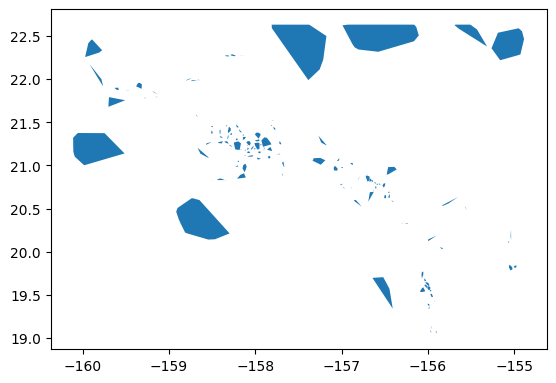

In [19]:
# quick plot the extracted polygons to check if everything worked fine
import geopandas
quick_plot = geopandas.GeoSeries(waypointsDF['PolygonObj'])
quick_plot.plot()

##### Routes identification

In [20]:
# for each LAT, LON pair, create a shapely.Point
concatDF['PointsObj'] = [shpl.Point(x,y) for (x,y) in concatDF[['LON', 'LAT']].values] #apparently this is faster than usig pandas.Dataframe.apply()

# for each WP, for each row of the entire dataset, check if the point is inside any WP
for name, polygon_obj in  waypointsDF[['Name', 'PolygonObj']].values:
    concatDF[str(name)] = polygon_obj.contains(concatDF['PointsObj']) # for each wp, create a new column containing either True or False

# list of column names just created
list_of_columns = [name for name in waypointsDF['Name']]

#idxmax: for each row, return the id (name) of the column containing the first occurrence of the maximum value. There are only bool values so True = 1 > False = 0
# basically returns the name of the WP where the point is contained. If the row has only 'False' values, it returns the first column (this is fixed below)
# this works under the assumption that any given point can belong to either zero or one WP.
concatDF['IsInWP'] = concatDF[list_of_columns].idxmax(axis=1)

# find all rows that have only 'False' values. The '~' negates the values (its like applying the binary NOT)
all_false_rows = concatDF[(~concatDF[list_of_columns]).all(axis=1)].index
# Replace the value in the 'IsInWP' column as 'None'
concatDF.loc[all_false_rows, 'IsInWP'] = None
# drop unnecessary columns
concatDF.drop(list_of_columns, axis=1, inplace=True)
concatDF.drop(['index', 'PointsObj'], axis=1, inplace=True)

display(concatDF.head(10))

/tmp/ipykernel_25975/3323970853.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/tmp/ipykernel_25975/3323970853.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/tmp/ipykernel_25975/3323970853.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/tmp/ipykernel_25975/3323970853.py:6: Performance

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,VesselType,Status,Length,Width,Draft,IsClassA,Avg_Speed,EstimatedStatus,IsInWP
0,382872,2019-01-08 19:32:26,21.3557,-157.9487,5.1,308.0,511.0,HARRIER,0,15,20,5,0.0,True,5.10,entry,WP_149
1,382872,2019-01-08 19:33:37,21.3569,-157.9501,5.2,316.5,511.0,HARRIER,0,15,20,5,0.0,True,5.40,sailing,WP_149
2,382872,2019-01-08 19:34:47,21.3580,-157.9514,5.2,300.0,511.0,HARRIER,0,15,20,5,0.0,True,5.06,sailing,WP_149
3,382872,2019-01-08 19:35:57,21.3584,-157.9532,5.2,274.0,511.0,HARRIER,0,15,20,5,0.0,True,5.33,sailing,WP_149
4,382872,2019-01-08 19:37:07,21.3578,-157.9548,5.1,232.0,511.0,HARRIER,0,15,20,5,0.0,True,4.97,sailing,WP_149
5,382872,2019-01-08 19:38:24,21.3571,-157.9565,5.2,247.7,511.0,HARRIER,0,15,20,5,0.0,True,4.86,sailing,WP_149
6,382872,2019-01-08 19:39:42,21.3563,-157.9584,5.2,242.2,511.0,HARRIER,0,15,20,5,0.0,True,5.39,sailing,WP_149
7,382872,2019-01-08 19:41:03,21.3555,-157.9603,5.2,246.0,511.0,HARRIER,0,15,20,5,0.0,True,5.19,sailing,WP_149
8,382872,2019-01-08 19:42:13,21.3550,-157.9621,5.2,258.4,511.0,HARRIER,0,15,20,5,0.0,True,5.41,sailing,WP_149
9,382872,2019-01-08 19:43:24,21.3546,-157.9638,5.2,257.9,511.0,HARRIER,0,15,20,5,0.0,True,4.98,sailing,WP_149


IsInWP
WP_152    2925926
None      1278799
WP_120     356533
WP_149     349206
WP_35       86235
           ...   
WP_71          50
WP_14          50
WP_10          47
WP_28          40
WP_142         39
Name: count, Length: 154, dtype: int64
(5460741, 17)


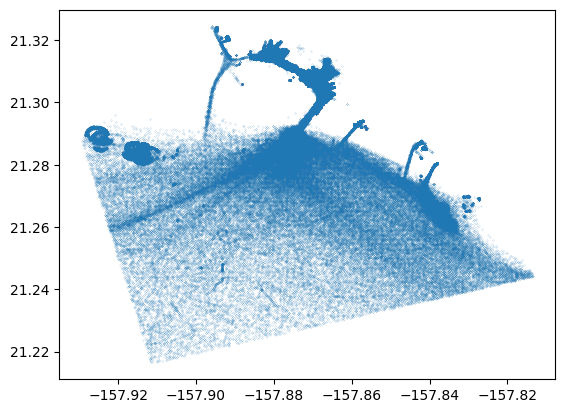

In [21]:
# count the number of points contained in each WP. 
# 'WP_X' -> the point is generated inside WP_X
# None -> the point does not belong to any cluster
value_counts = concatDF['IsInWP'].value_counts(dropna=False)
print(value_counts)
print(concatDF.shape)
# quick plot of the WP with the highest amount of points
testDF = concatDF[concatDF['IsInWP'] == value_counts.index[0]]
plt.scatter(testDF['LON'], testDF['LAT'], s=0.01)

#### Routes extraction
For each vessel contained in V_s (used at the beginning of this notebook), create a new column (called 'Route') specifying the current route.</br>If the ship is inside a WP, than the WP name is used in the new column.</br>If the ship is at open sea ('IsInWP' == None) then the Route column is filled in the following way:
* let A and B be the names of the start and end WPs, respectively. In order for them to be considered, they need to be either 'entry' or 'exit' WPs, or the vessel needs to generate at least one stationary point inside them
* if both A and B are known, the route name is built as A - B
* if either one is missing (pd.NA), the route name is built as "\<NA> - B" or "A - \<NA>"

In [22]:
concatDF['IsInSignificantWP'] = p.Series(dtype=p.StringDtype())
concatDF['Route'] = p.Series(dtype=p.StringDtype())
print(concatDF.shape)
for index, unique_mmsi in enumerate(reference_list_of_mmsi):
    vesselDF = concatDF[concatDF['MMSI'] == unique_mmsi].copy().reset_index(drop=True)
    vesselDF['IsInSignificantWP'] = p.Series(dtype=p.StringDtype()) # new empty column
    vesselDF['PreviousWP'] = p.Series(dtype=p.StringDtype())
    vesselDF['NextWP'] = p.Series(dtype=p.StringDtype())
    # extract the indeces of any entry-exit pair of points
    entry_points_index = vesselDF[vesselDF['EstimatedStatus'] == 'entry'].index.to_list()
    exit_points_index = vesselDF[vesselDF['EstimatedStatus'] == 'exit'].index.to_list()
    entry_exit_pairs_list = list(zip(entry_points_index, exit_points_index))
    # check formal validity of entry/exit pairs
    for idx, pair in enumerate(entry_exit_pairs_list):
        entry_idx, exit_idx = pair[0], pair[1]
        sub_range = range(entry_idx, exit_idx+1)            
        next_item = entry_exit_pairs_list[(idx + 1) % len(entry_exit_pairs_list)]
        if ((exit_idx + 1) != next_item[0]) and (idx+1 != len(entry_exit_pairs_list)):
            print(f'Error for tuples {pair}, {next_item} for vessel {unique_mmsi} with index {index}')
            break
        # if the pair is valid, extract the routes

        # create a new column for storing when a point is in a WP with a Avg_Speed lower than the threshold used for stationary points
        significantWP_condition = ( (vesselDF.loc[sub_range, 'Avg_Speed'] <= c.SPEED_THRESHOLD)
                                    | (vesselDF.loc[sub_range, 'EstimatedStatus'] == 'entry')
                                    | (vesselDF.loc[sub_range, 'EstimatedStatus'] == 'exit') 
                                   )

        vesselDF.loc[sub_range, 'IsInSignificantWP'] = np.where(significantWP_condition, vesselDF.loc[sub_range, 'IsInWP'], None)
  
        # create a new column where each row contains the name of the previous WP
        vesselDF.loc[sub_range, 'PreviousWP'] = vesselDF.loc[sub_range, 'IsInSignificantWP'].ffill()
        
        # create a new column where each row contains the name of the following WP
        vesselDF.loc[sub_range, 'NextWP'] = vesselDF.loc[sub_range, 'IsInSignificantWP'].bfill()
    
        #replace None values with pandas.NA, which is like np.NaN but for non-numeric values
        vesselDF.loc[sub_range, 'PreviousWP'] = vesselDF.loc[sub_range, 'PreviousWP'].fillna(p.NA)
        vesselDF.loc[sub_range, 'NextWP'] = vesselDF.loc[sub_range, 'NextWP'].fillna(p.NA)
        
        # create the route name as 'A - B'
        vesselDF.loc[sub_range, 'Route'] = vesselDF.loc[sub_range, 'IsInSignificantWP'].combine_first(vesselDF.loc[sub_range, 'PreviousWP'].astype(str) + ' - ' + vesselDF.loc[sub_range, 'NextWP'].astype(str))

    # remove auxiliary columns that aren't necessary anymore
    vesselDF.drop(['PreviousWP', 'NextWP'], axis=1, inplace=True)
    #save df to the list of vessels (V_s)
    V_s[index] = vesselDF.copy()

concatDF = p.concat(V_s).copy()
#print(V_s[200][['BaseDateTime', 'MMSI', 'LAT', 'LON', 'EstimatedStatus', 'Avg_Speed', 'IsInWP','IsInSignificantWP', 'Route']].to_string())
display(V_s[0].loc[0:100])

(5460741, 19)


/tmp/ipykernel_25975/3347029058.py:42: FutureWarning:

The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.

/tmp/ipykernel_25975/3347029058.py:42: FutureWarning:

The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.

/tmp/ipykernel_25975/3347029058.py:42: FutureWarning:

The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.

/tmp/ipykernel_25975/3347029058.py:42: FutureWarning:

The behavior of array concaten

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,VesselType,Status,Length,Width,Draft,IsClassA,Avg_Speed,EstimatedStatus,IsInWP,IsInSignificantWP,Route
0,382872,2019-01-08 19:32:26,21.3557,-157.9487,5.1,308.0,511.0,HARRIER,0,15,20,5,0.0,True,5.10,entry,WP_149,WP_149,WP_149
1,382872,2019-01-08 19:33:37,21.3569,-157.9501,5.2,316.5,511.0,HARRIER,0,15,20,5,0.0,True,5.40,sailing,WP_149,<NA>,WP_149 - WP_149
2,382872,2019-01-08 19:34:47,21.3580,-157.9514,5.2,300.0,511.0,HARRIER,0,15,20,5,0.0,True,5.06,sailing,WP_149,<NA>,WP_149 - WP_149
3,382872,2019-01-08 19:35:57,21.3584,-157.9532,5.2,274.0,511.0,HARRIER,0,15,20,5,0.0,True,5.33,sailing,WP_149,<NA>,WP_149 - WP_149
4,382872,2019-01-08 19:37:07,21.3578,-157.9548,5.1,232.0,511.0,HARRIER,0,15,20,5,0.0,True,4.97,sailing,WP_149,<NA>,WP_149 - WP_149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,382872,2019-01-08 21:25:36,21.3532,-157.9402,0.0,93.3,511.0,HARRIER,0,15,20,5,0.0,True,0.00,stationary,None,<NA>,WP_149 - WP_149
97,382872,2019-01-08 21:26:46,21.3532,-157.9402,0.0,88.1,511.0,HARRIER,0,15,20,5,0.0,True,0.00,stationary,None,<NA>,WP_149 - WP_149
98,382872,2019-01-08 21:27:56,21.3532,-157.9402,0.0,82.7,511.0,HARRIER,0,15,20,5,0.0,True,0.00,stationary,None,<NA>,WP_149 - WP_149
99,382872,2019-01-08 21:29:07,21.3531,-157.9402,0.0,0.0,511.0,HARRIER,0,15,20,5,0.0,True,0.30,stationary,None,<NA>,WP_149 - WP_149


##### Plot ship path on a map

In [23]:
# dataframe structure should be the same of "concatDF"
to_be_plotted = V_s[0]
f.plot_routes(to_be_plotted, clusteredPointsDF, "SingleVessel")

#### Search for the most popular routes

In [24]:
def count_groups(df, col_name):
    df['shifted'] = df[col_name].shift(1)
    df['change'] = df[col_name] != df['shifted']
    df['group'] = df['change'].cumsum()
    group_counts = df.groupby('group')[col_name].first().value_counts()
    return group_counts

result = {}

for temp_vessel in V_s:
    group_counts = count_groups(temp_vessel, 'Route')
    for key, count in group_counts.items():
        if key not in result.keys():
            result[key] = count
        else:
            result[key] += count

tempDF = p.DataFrame(data={'Name': result.keys(), 'Count': result.values()}).sort_values(by='Count', ascending=False).to_string()
print(tempDF)

                Name  Count
4             WP_152  18683
5    WP_152 - WP_152  17262
0             WP_149   7576
1    WP_149 - WP_149   7446
760           WP_131   2928
761  WP_131 - WP_131   2926
76            WP_136   2183
73            WP_120   2042
77   WP_136 - WP_136   2030
43             WP_96   1982
82   WP_120 - WP_120   1703
98     WP_96 - WP_96   1615
93             WP_35   1226
83             WP_11   1143
129    WP_35 - WP_35   1055
84     WP_11 - WP_11   1017
35             WP_80    700
80     WP_80 - WP_80    560
33             WP_30    526
8      WP_152 - <NA>    438
41     WP_30 - WP_30    429
11     <NA> - WP_152    424
32             WP_61    409
56             WP_66    341
71             WP_77    325
165           WP_146    299
247    WP_61 - WP_96    287
46     WP_96 - WP_61    286
104           WP_133    284
166  WP_146 - WP_146    280
106  WP_133 - WP_133    274
605            WP_94    274
58     WP_66 - WP_66    237
265    WP_77 - WP_77    201
606    WP_94 - WP_94

In [25]:
display(concatDF[concatDF['Route'].isnull()])
concatDF = concatDF[concatDF['Route'].notna()]
display(concatDF[concatDF['Route'].isnull()])

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,VesselType,Status,Length,Width,Draft,IsClassA,Avg_Speed,EstimatedStatus,IsInWP,IsInSignificantWP,Route
0,182083130,2019-02-28 09:28:52,22.5822,-155.6414,55.8,31.9,490.0,<NA>,0,99,0,0,NaN,False,55.8,exit,None,<NA>,<NA>
0,189750956,2019-01-25 08:13:49,20.6338,-155.6523,56.7,299.9,37.0,<NA>,0,99,0,0,NaN,False,56.7,exit,None,<NA>,<NA>
0,305367161,2019-01-28 12:15:02,21.8343,-155.4291,11.4,262.6,257.0,<NA>,0,0,0,0,NaN,True,11.4,exit,None,<NA>,<NA>
0,338326458,2019-01-29 23:36:58,21.3063,-157.8633,0.0,135.5,151.0,<NA>,0,0,0,0,NaN,True,0.0,exit,WP_152,<NA>,<NA>
0,338593071,2019-01-28 07:07:09,21.3201,-157.8671,0.0,361.0,511.0,<NA>,0,0,0,0,NaN,True,0.0,exit,None,<NA>,<NA>
0,366122928,2019-01-05 16:45:44,21.1444,-157.6381,8.0,297.2,299.0,<NA>,0,0,0,0,NaN,True,8.0,exit,None,<NA>,<NA>
0,366294424,2019-03-22 03:54:49,21.3148,-157.8772,0.0,322.8,511.0,<NA>,0,99,0,0,NaN,False,0.0,exit,WP_152,<NA>,<NA>
0,366299856,2019-01-20 06:24:58,21.3119,-157.8779,9.7,166.1,122.0,<NA>,0,0,0,0,NaN,True,9.7,exit,WP_152,<NA>,<NA>
0,366932155,2019-03-13 19:02:33,21.3101,-157.8679,9.6,354.2,161.0,<NA>,0,8,0,0,NaN,True,9.6,exit,WP_152,<NA>,<NA>
0,367248818,2019-02-01 20:43:31,21.2804,-157.8382,0.1,133.7,511.0,<NA>,0,0,0,0,NaN,True,0.1,exit,WP_152,<NA>,<NA>


,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,VesselType,Status,Length,Width,Draft,IsClassA,Avg_Speed,EstimatedStatus,IsInWP,IsInSignificantWP,Route


In [26]:
# column of booleans. If true, then the point belongs to a route, false otherwise
concatDF['IsInRoute'] = concatDF['Route'].str.contains('-')

# plot all points given a certain route
# ----- Specify route name here --------
#route_name = 'WP_61' + ' - ' + 'WP_96'
route_name = 'WP_152' + ' - ' + 'WP_120'
# ----- changing the dataset often requires to change the route name above -----
chosen_points = concatDF[concatDF['Route'] == route_name].copy()
#f.plot_routes(chosen_points, clusteredPointsDF, mode='SingleRoute')
tempplot = f.route_arrows_plot(inputDF=chosen_points.head(int((chosen_points.size))), color_criteria='Avg_Speed', scale_factor=0.000000000005)
po.plot(tempplot, auto_open=True)

# create a list of Dataframes (each representing a single route)
# compare a value of 'IsInRoute' with the following one. If the opposite (~) of the second is different,
# then set the value of 'group' as '1' (boolean True converted to int. Int8 is chosen to save memory)
concatDF['group'] = concatDF['group'] = (concatDF['IsInRoute'] & (~concatDF['IsInRoute'].shift(1, fill_value=False))).astype(p.Int8Dtype())
# calculate the cumulative sum of each group. Every time a new '1' is found, the cumsum is increased
concatDF['trip_id'] = concatDF['group'].cumsum() # trip_id is basically the id of each route
# Extract only the points for which "IsInRoute" is set to True and also belong to the specified route
only_route_points = concatDF[(concatDF['IsInRoute'] == True) & (concatDF['Route'] == route_name)]
# group route points by their trip_id and save each resulting group_data separately into a list
list_of_trips = [route for _, route in only_route_points.groupby('trip_id')]
concatDF.drop('group', axis=1)
# check the list of routes before exporting it
lengths = [len(x) for x in list_of_trips]
print(f"mean: {s.mean(lengths)}, median: {s.median(lengths)}, min: {min(lengths)}, max: {max(lengths)}: routes: {len(lengths)}, moda: {s.mode(lengths)}")

mean: 110.59358288770053, median: 96, min: 41, max: 524: routes: 187, moda: 78


In [27]:
# print five random trips to check that the code above works properly
from random import sample
indexes = sample(range(0, len(list_of_trips)), 5)

for i in indexes:
    f.route_plot(inputDF=list_of_trips[i],
                 title=f'Index: {i}, Test {list_of_trips[i].iloc[0,list_of_trips[i].columns.get_loc("MMSI")]}',
                 color_criteria='Avg_Speed',
                 hover_data=['MMSI'])

In [28]:
# Check how many vessels partecipate to the chosen route
test_groupby = only_route_points.groupby('MMSI')['MMSI'].count().reset_index(name='count')
display(test_groupby.sort_values(by="count", ascending=False))
print(f'There are {test_groupby["MMSI"].shape[0]} different vessels that take this route:\n{test_groupby["MMSI"].to_list()}')
f.route_plot(inputDF=only_route_points[only_route_points['MMSI'] == 367309860], color_criteria="Avg_Speed")

,MMSI,count
23,367309860,3168
28,367416420,2007
16,367008740,1890
29,367420170,1758
27,367389160,1223
30,367472000,1066
34,367776660,971
18,367017630,924
9,366873510,837
26,367310270,724


There are 43 different vessels that take this route:
[245011000, 303174000, 311017100, 338115054, 338210969, 338242587, 338272000, 356774000, 366766970, 366873510, 366914410, 366953000, 366972620, 366999665, 367007870, 367007920, 367008740, 367008770, 367017630, 367055690, 367133450, 367151310, 367309120, 367309860, 367309890, 367310240, 367310270, 367389160, 367416420, 367420170, 367472000, 367515670, 367648550, 367730340, 367776660, 367793430, 368477000, 477229900, 518100014, 518100015, 518100405, 538004149, 538004472]


In [29]:
display(list_of_trips[2].head(5))
display(list_of_trips[2].tail(5))
display(concatDF.head(5))

# Save the result to a binary pickle file so that it can be imported by the next ipynb
with open('../out/TREAD_out.pkl', 'wb') as file:
    pickle.dump((concatDF, list_of_trips, route_name), file)

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,VesselType,Status,...,Draft,IsClassA,Avg_Speed,EstimatedStatus,IsInWP,IsInSignificantWP,Route,IsInRoute,group,trip_id
2169,311017100,2019-01-06 18:16:40,21.3144,-157.8844,0.9,63.0,274.0,GULF RASTAQ,80,0,...,12.2,True,0.93,sailing,WP_152,<NA>,WP_152 - WP_120,True,1,1892
2170,311017100,2019-01-06 18:17:50,21.3145,-157.8840,1.2,75.0,269.0,GULF RASTAQ,80,0,...,12.2,True,1.19,sailing,WP_152,<NA>,WP_152 - WP_120,True,0,1892
2171,311017100,2019-01-06 18:19:10,21.3147,-157.8834,1.6,69.0,263.0,GULF RASTAQ,80,0,...,12.2,True,1.61,sailing,WP_152,<NA>,WP_152 - WP_120,True,0,1892
2172,311017100,2019-01-06 18:20:20,21.3150,-157.8829,1.8,53.0,248.0,GULF RASTAQ,80,0,...,12.2,True,1.71,sailing,WP_152,<NA>,WP_152 - WP_120,True,0,1892
2173,311017100,2019-01-06 18:21:30,21.3154,-157.8825,1.6,43.0,230.0,GULF RASTAQ,80,0,...,12.2,True,1.69,sailing,WP_152,<NA>,WP_152 - WP_120,True,0,1892


,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,VesselType,Status,...,Draft,IsClassA,Avg_Speed,EstimatedStatus,IsInWP,IsInSignificantWP,Route,IsInRoute,group,trip_id
2281,311017100,2019-01-06 21:11:01,21.3251,-158.1141,1.6,123.0,170.0,GULF RASTAQ,80,0,...,12.2,True,1.71,sailing,WP_120,<NA>,WP_152 - WP_120,True,0,1892
2282,311017100,2019-01-06 21:12:30,21.3248,-158.1136,1.2,112.0,195.0,GULF RASTAQ,80,0,...,12.2,True,1.35,sailing,WP_120,<NA>,WP_152 - WP_120,True,0,1892
2283,311017100,2019-01-06 21:13:51,21.3246,-158.1132,0.9,120.0,206.0,GULF RASTAQ,80,0,...,12.2,True,1.13,sailing,WP_120,<NA>,WP_152 - WP_120,True,0,1892
2284,311017100,2019-01-06 21:15:01,21.3244,-158.1129,1.0,133.0,216.0,GULF RASTAQ,80,0,...,12.2,True,1.06,sailing,WP_120,<NA>,WP_152 - WP_120,True,0,1892
2285,311017100,2019-01-06 21:17:01,21.3241,-158.1126,0.5,133.0,226.0,GULF RASTAQ,80,0,...,12.2,True,0.74,sailing,WP_120,<NA>,WP_152 - WP_120,True,0,1892


,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,VesselType,Status,...,Draft,IsClassA,Avg_Speed,EstimatedStatus,IsInWP,IsInSignificantWP,Route,IsInRoute,group,trip_id
0,382872,2019-01-08 19:32:26,21.3557,-157.9487,5.1,308.0,511.0,HARRIER,0,15,...,0.0,True,5.10,entry,WP_149,WP_149,WP_149,False,0,0
1,382872,2019-01-08 19:33:37,21.3569,-157.9501,5.2,316.5,511.0,HARRIER,0,15,...,0.0,True,5.40,sailing,WP_149,<NA>,WP_149 - WP_149,True,1,1
2,382872,2019-01-08 19:34:47,21.3580,-157.9514,5.2,300.0,511.0,HARRIER,0,15,...,0.0,True,5.06,sailing,WP_149,<NA>,WP_149 - WP_149,True,0,1
3,382872,2019-01-08 19:35:57,21.3584,-157.9532,5.2,274.0,511.0,HARRIER,0,15,...,0.0,True,5.33,sailing,WP_149,<NA>,WP_149 - WP_149,True,0,1
4,382872,2019-01-08 19:37:07,21.3578,-157.9548,5.1,232.0,511.0,HARRIER,0,15,...,0.0,True,4.97,sailing,WP_149,<NA>,WP_149 - WP_149,True,0,1
